Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step 1000, Reward: -0.1407
PSNR: 4.94


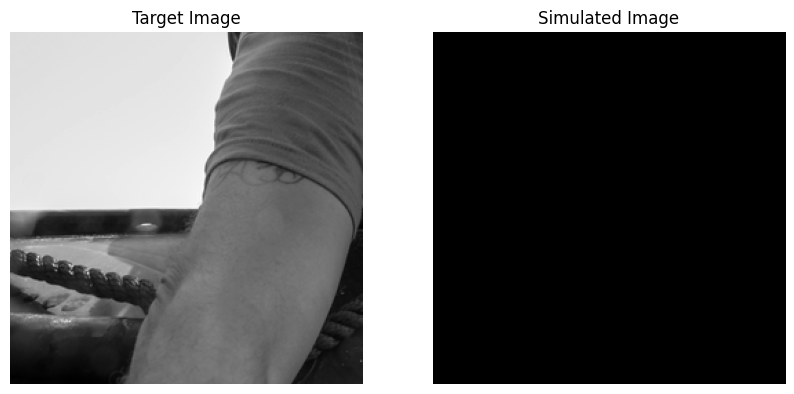

Step 2000, Reward: -0.1421
PSNR: 4.94


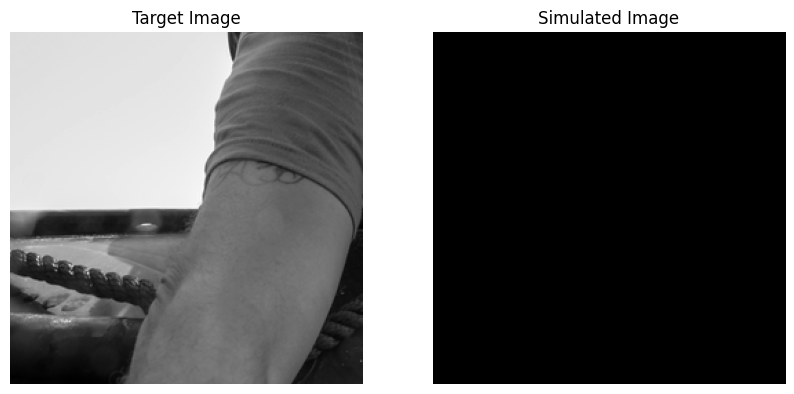

Step 3000, Reward: -0.1427
PSNR: 4.94


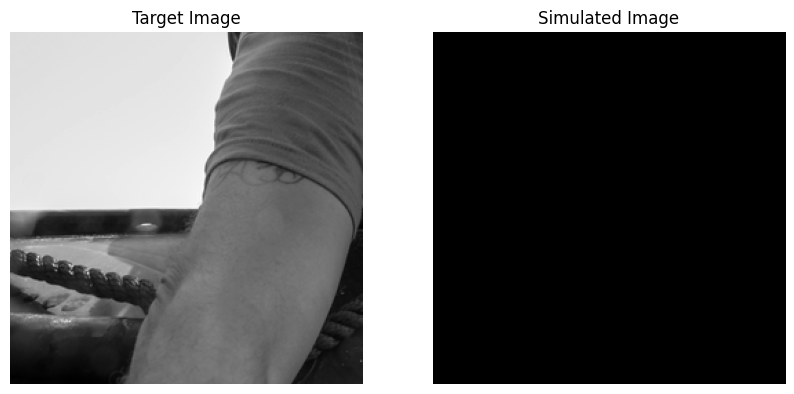

Step 4000, Reward: -0.1440
PSNR: 4.94


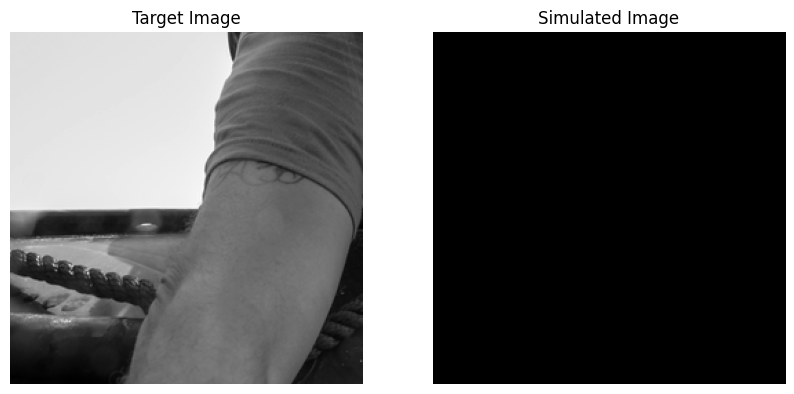

Step 5000, Reward: -0.1441
PSNR: 4.94


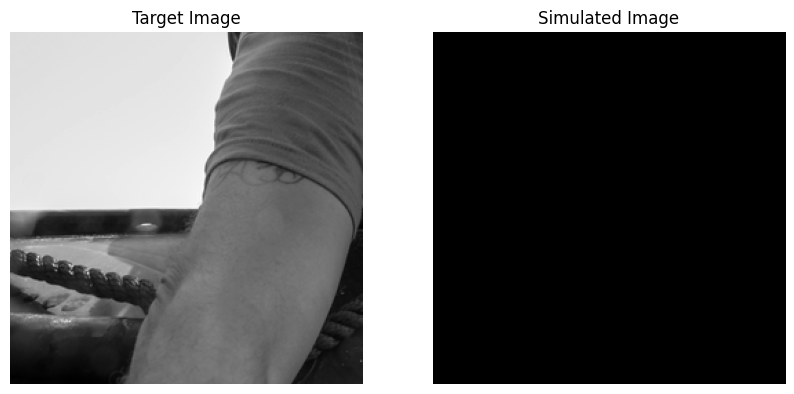

Step 6000, Reward: -0.1463
PSNR: 4.94


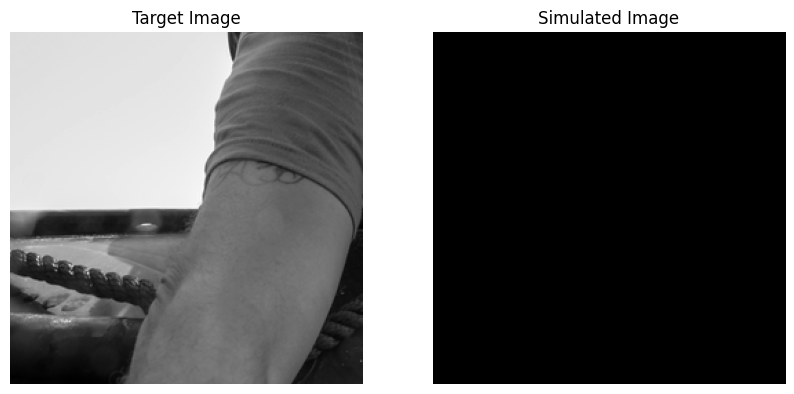

KeyboardInterrupt: 

In [9]:
import gymnasium as gym
import torch
import torch.nn as nn
import torchOptics.optics as tt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

# Define Dataset and Parameters
folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/'  # Dataset folder
device = 'cuda'  # Define device
z = 2e-3  # Propagation distance
meta = {'dx': [6.3e-6, 6.3e-6], 'wl': [515e-9]}  # Pixel pitch
grid_size = 256  # Resolution of action space
model_save_path = "./sac_cgh_model"  # Path to save the model

# Define Environment
class CGHOpticsEnv(gym.Env):
    """
    CGH Optics Environment for Reinforcement Learning
    """
    def __init__(self, dataset, meta, grid_size, z, device):
        super(CGHOpticsEnv, self).__init__()
        self.dataset = dataset
        self.meta = meta
        self.grid_size = grid_size
        self.z = z
        self.device = device

        self.action_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(grid_size, grid_size), dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(grid_size, grid_size), dtype=np.float32
        )

        self.current_image = None
        self.reset()

    def reset(self, seed=None, **kwargs):
        """
        Reset the environment to the initial state
        """
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.current_image = self._get_random_image()
        self.field = torch.ones((1, 1, self.grid_size, self.grid_size), device=self.device)  # Initial field
        return self.current_image.cpu().numpy(), {}

    def step(self, action):
        """
        Perform an action in the environment
        """
        # Apply action to the field
        field = tt.Tensor(
            torch.tensor(action, dtype=torch.float32, device=self.device).unsqueeze(0).unsqueeze(0),
            meta=self.meta
        )

        # Simulate output field
        simulated = tt.simulate(field, -self.z).abs() ** 2
        reward = -nn.MSELoss()(simulated, self.current_image).item()

        # Determine termination
        terminated = reward > -1e-3
        truncated = False
        return simulated.cpu().numpy(), reward, terminated, truncated, {}

    def _get_random_image(self):
        """
        Retrieve a random image from the dataset
        """
        index = np.random.randint(len(self.dataset))
        image = self.dataset[index][0].to(self.device)
        return image

# Define Dataset
dataset = tt.MultiImageDatasetImageio(
    folder,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomCrop((grid_size, grid_size), pad_if_needed=True)
    ])
)

class CustomCallback(BaseCallback):
    def _on_step(self) -> bool:
        # Step마다 로그 출력
        if self.n_calls % 1000 == 0:
            print(f"Step {self.n_calls}, Reward: {self.locals['rewards'][-1]:.4f}")

            # 현재 target image 및 simulated image 가져오기
            env = self.training_env.envs[0]
            target = env.current_image.squeeze().cpu().numpy()  # (256, 256)
            simulated = env.field.squeeze().cpu().detach().numpy()  # (256, 256)

            # PSNR 계산
            mse = np.mean((target - simulated) ** 2)
            psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else float('inf')
            print(f"PSNR: {psnr:.2f}")

            # 시각화
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Target Image")
            plt.imshow(target, cmap="gray")  # 2D로 전달
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.title("Simulated Image")
            plt.imshow(simulated, cmap="gray")  # 2D로 전달
            plt.axis("off")

            plt.show()
        return True

# Initialize Environment and Model
env = CGHOpticsEnv(dataset, meta, grid_size, z, device)
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0003,
    buffer_size=10000,
    optimize_memory_usage=False
)

# Train Model
model.learn(total_timesteps=50000, callback=CustomCallback())

# Save the Trained Model
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

# Evaluate Trained Model
obs, _ = env.reset()
for _ in range(10):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated:
        print("Training Complete!")
        break

# Visualize Results
tt.show_with_insets(env.current_image, env.current_image)
tt.show_with_insets(tt.simulate(tt.Tensor(torch.tensor(action).unsqueeze(0).unsqueeze(0).to(device), meta=meta), -z).abs()**2, env.current_image)
